In [1]:
import numpy as np
import pandas as pd
import datetime
from pandas_datareader import data, wb, DataReader
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.plotting import figure, show, output_file
from scipy.stats import norm
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

### Step 1. Create a Python function that receives 4 parameters:
##### 1) Stock ticket;
##### 2) ndays2hold = maximum number of days you would like to hold the stock;
##### 3) ndays2history = number of historic days you will measure the return and built the histogram of returns - default 200 days;
##### 4) aggressive = True/False. If aggresive equals to yes, you should label as 1 the best 5% of the ndays2history and 0 as the rest. If aggressive = False, you should label as 1 the 33% best of the ndays2history and 0 as the rest.
##### Your function should return a dataset labeled with a column y according to the previous parameters.

In [2]:
# En un principio esta función, además de hacer la llamada a la API, también etiquetaba las oportunidades como 1 o 0 cero pero
# finalmente y para optimizar el rendimiento teniendo que etiquetar menos registros hemos desplazado la funcionalidad del
# 'labeling on aggressive' a las siguientes funciones del ejercicio. 

def create_lagged_series(stock_ticket, ndays2hold, ndays2history=200):
    lags = int(ndays2hold)
    tsret = pd.DataFrame()

    # Obtain stock information from google Finance (3 times ndays2history to have rows enough for dev and oot building)
    days_calc = 3 * ndays2history + ndays2hold + 200
    start_date = datetime.datetime.today() - BDay(days_calc)
    end_date = datetime.datetime.today()
    tslag = data.DataReader(stock_ticket, "google", start_date, end_date)
    tslag = tslag.reindex(index=tslag.index[::-1])
    tslag['LagHigh_rollingmax'] = pd.rolling_max(tslag["High"], window = lags+1) #moving window max value
    
    #Create new DataFrame tsret only with returns for histogram buliding
    tsret = pd.DataFrame(index=tslag.index)    
    tsret['LagHigh_%'] = (tslag['LagHigh_rollingmax']-tslag['Low'] ) / (tslag['Low']) 
    
    tslag['LagHigh_%'] = (tslag['LagHigh_rollingmax']-tslag['Low'] ) / (tslag['Low'])
    
    #Build histogram
    #hist, edges = np.histogram(tsret, range=(-0.2,0.2))
    hist, edges = np.histogram(tsret, range=(-0.2,0.2))
    total_muestra = sum(hist)
    hist = hist / float(total_muestra)
    hist_title = stock_ticket + " histogram, lags: " + str(lags)
    p1 = figure(title = hist_title, background_fill_color="#E8DDCB")
    p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")
    p1.legend.location = "top_left"
    p1.xaxis.axis_label = '% Earnings'
    p1.yaxis.axis_label = 'Probability'
    output_file('./histogram.html', title=hist_title )
    show(p1)
    
    tsretl = tslag[lags:]
    return tsretl

In [3]:
ts_1 = create_lagged_series('AMZN', 10, 200)

C:\Users\Alberto\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=11,center=False).max()
C:\Users\Alberto\Anaconda2\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\Alberto\Anaconda2\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


In [4]:
len(ts_1)

772

In [5]:
ts_1.head()

,Open,High,Low,Close,Volume,LagHigh_rollingmax,LagHigh_%
Date,,,,,,,
2017-07-14,1002.40,1004.45,996.89,1001.81,2102469,1083.31,0.086690
2017-07-13,1004.62,1006.88,995.90,1000.63,2880769,1083.31,0.087770
2017-07-12,1000.65,1008.55,998.10,1006.51,3608574,1053.20,0.055205
2017-07-11,993.00,995.99,983.72,994.13,2982726,1043.33,0.060597
2017-07-10,985.00,999.44,983.50,996.47,3546268,1043.01,0.060508


In [6]:
ts_1.tail()

,Open,High,Low,Close,Volume,LagHigh_rollingmax,LagHigh_%
Date,,,,,,,
2014-06-27,325.88,326.52,323.27,324.57,2419626,355.77,0.100535
2014-06-26,328.49,328.65,322.13,325.69,2699908,347.00,0.077205
2014-06-25,324.33,328.15,321.74,327.44,2328006,338.30,0.051470
2014-06-24,327.54,329.73,322.74,324.16,2627978,338.30,0.048212
2014-06-23,323.33,327.55,321.41,327.24,2609628,338.30,0.052550


In [7]:
ts_1.index[-1], ts_1.index[0]

(Timestamp('2014-06-23 00:00:00'), Timestamp('2017-07-14 00:00:00'))

### Step 2. Create as dev sample calculating the following variables (repeating it for each day for ndays2history days):
##### - Current Price
##### - Price Moving averages 10 days, 20 days, 50 days 100 days
##### - Current Volume
##### - Volume Moving averages 10 days, 20 days, 50 days 100 days
##### - Trading range (difference between high and low prices): last day, day, 10 days, 20 days, 50 days, 100 days
##### - Moving average of trading range (hi-low): 10 days, 20 days, 50 days, 100 days
##### - Number of consecutive days going up (zero if price today/price yesterday < 1)
##### - Number of consecutive days going down (zero if price today/price yesterday > 1)
##### - Beta, alpha, r-squared, volatility, momentum
##### - VaR (Value at Risk)

In [3]:
def calculating_variables(ts, ndays2history, aggressive = True):
    ts = ts[:(200 + ndays2history)] # 200 rows to get Beta for each day in ndays2history (moving window)
    ts = ts.reindex(index=ts.index[::-1])
    
    # Current price -> Close price
    # Price moving averages
    ts['PMA_10days'] = pd.rolling_mean(ts['Close'], window = 10)
    ts['PMA_20days'] = pd.rolling_mean(ts['Close'], window = 20)
    ts['PMA_50days'] = pd.rolling_mean(ts['Close'], window = 50)
    ts['PMA_100days'] = pd.rolling_mean(ts['Close'], window = 100)  
    
    # Open price moving averages
    ts['OPMA_10days'] = pd.rolling_mean(ts['Open'], window = 10)
    ts['OPMA_20days'] = pd.rolling_mean(ts['Open'], window = 20)
    ts['OPMA_50days'] = pd.rolling_mean(ts['Open'], window = 50)
    ts['OPMA_100days'] = pd.rolling_mean(ts['Open'], window = 100)    
    
    # High price moving averages
    ts['HPMA_10days'] = pd.rolling_mean(ts['High'], window = 10)
    ts['HPMA_20days'] = pd.rolling_mean(ts['High'], window =20)
    ts['HPMA_50days'] = pd.rolling_mean(ts['High'], window = 50)
    ts['HPMA_100days'] = pd.rolling_mean(ts['High'], window = 100)
    
    # Low price moving averages
    ts['LPMA_10days'] = pd.rolling_mean(ts['Low'], window = 10)
    ts['LPMA_20days'] = pd.rolling_mean(ts['Low'], window =20)
    ts['LPMA_50days'] = pd.rolling_mean(ts['Low'], window = 50)
    ts['LPMA_100days'] = pd.rolling_mean(ts['Low'], window = 100)    
    
    #Volume moving averages
    ts['VMA_10days'] = pd.rolling_mean(ts['Volume'], window = 10)
    ts['VMA_20days'] = pd.rolling_mean(ts['Volume'], window =20)
    ts['VMA_50days'] = pd.rolling_mean(ts['Volume'], window = 50)
    ts['VMA_100days'] = pd.rolling_mean(ts['Volume'], window = 100)
    
    # trading range (hi-low): day, last day, 10 days, 20 days, 50 days, 100 days
    ts['TR_daily'] = ts['High'] - ts['Low']
    ts['TR_last_day'] = pd.rolling_max(ts['High'], window = 2)  - pd.rolling_min(ts['Low'], window = 2)
    ts['TR_10days'] = pd.rolling_max(ts['High'], window = 10)  - pd.rolling_min(ts['Low'], window = 10)
    ts['TR_20days'] = pd.rolling_max(ts['High'], window = 20)  - pd.rolling_min(ts['Low'], window = 20)
    ts['TR_50days'] = pd.rolling_max(ts['High'], window = 50)  - pd.rolling_min(ts['Low'], window = 50)
    ts['TR_100days'] = pd.rolling_max(ts['High'], window = 100)  - pd.rolling_min(ts['Low'], window = 100)
    
    # Moving averages of trading range (hi-low): 10 days, 20 days, 50 days, 100 days
    ts['TRMA_10days'] = pd.rolling_mean(ts['TR_daily'], window = 10)
    ts['TRMA_20days'] = pd.rolling_mean(ts['TR_daily'], window = 20)
    ts['TRMA_50days'] = pd.rolling_mean(ts['TR_daily'], window = 50)
    ts['TRMA_100days'] = pd.rolling_mean(ts['TR_daily'], window = 100)
    
    # Number of consecutives days going up, zero if price today / price yesterday < 1.0
    ts['ndays_up'] = ''
    global counter_up
    counter_up = 0
    for i in range(1, len(ts['Close'])):
        res = ts['Close'][i] / ts['Close'][i-1]
        if res > 1:
            counter_up += 1
            ts['ndays_up'][i] = counter_up
        else:
            counter_up = 0
            ts['ndays_up'][i] = counter_up
            
    # Number of consecutives days going down, zero if price today / price yesterday > 1.0
    ts['ndays_down'] = ''
    global counter_down 
    counter_down = 0
    for i in range(1, len(ts['Close'])):
        res = ts['Close'][i] / ts['Close'][i-1]
        if res < 1:
            counter_down += 1
            ts['ndays_down'][i] = counter_down
        else:
            counter_down = 0
            ts['ndays_down'][i] = counter_down
            
    # Beta, alpha, r-squared, volatility, momentum & VaR
    dfb = data.DataReader('SPY', 'google', ts.index[0], ts.index[-1])
    ts['rets'] = ts['Close'] / ts['Close'].shift(1) - 1
    ts['Index_close'] = dfb['Close']
    ts['Index_rets'] = dfb['Close'] / dfb['Close'].shift(1) - 1

    ts['beta'] = ''
    ts['alpha'] = ''
    ts['r_squared'] = ''
    ts['volatility'] = ''
    ts['momentum'] = ''
    ts['VaR'] = ''
    
    def var_cov_var(P, c, mu, sigma):
        alpha = norm.ppf(1-c, mu, sigma)
        return P - P*(alpha + 1)

    for i in range(200, len(ts['rets']-199)):
        ts_rets = ts['rets'][i-199:i+1]
        ts_index = ts['Index_rets'][i-199:i+1]
        covmat = np.cov(ts_rets, ts_index)
        beta = covmat[0,1]/covmat[1,1]
        ts['beta'][i] = beta
        alpha = np.mean(ts_rets)-beta*np.mean(ts_index)
        ts['alpha'][i] = alpha
        ypred = alpha + beta * ts_index
        SS_res = np.sum(np.power(ypred-ts_rets,2))
        SS_tot = covmat[0,0]*(len(ts)-1)
        ts['r_squared'][i] = 1. - SS_res/SS_tot
        volatility = np.sqrt(covmat[0,0])
        ts['volatility'][i] = volatility
        momentum = np.prod(1+ts_rets.tail(20).values)-1 #1 month momentum (20 last rows)
        ts['momentum'][i] = momentum
        P = 1e6   # 1,000,000 USD
        c = 0.99  # 99% confidence interval
        mu = np.mean(ts_rets)
        sigma = np.std(ts_rets)
        var = var_cov_var(P, c, mu, sigma)
        ts['VaR'][i] = var
    
    #Depending on how to set up the aggressive parameter:
    tsretl = ts[200:] 
    
    if aggressive == True: # mark as '1' the 5% best opportunities, '0' otherwise
        perc = tsretl['LagHigh_%'].quantile(0.95)
        tsretl['y'] = np.nan
        for i in range(len(tsretl['LagHigh_%'])):
            if tsretl['LagHigh_%'][i] > perc:
                tsretl['y'][i] = 1
            else:
                tsretl['y'][i] = 0
        return tsretl
    else: # mark as '1' the 33% best opportunities, '0' otherwise
        perc = tsretl['LagHigh_%'].quantile(0.67)
        tsretl['y'] = np.nan
        for i in range(len(tsretl['LagHigh_%'])):
            if tsretl['LagHigh_%'][i] > perc:
                tsretl['y'][i] = 1
            else:
                tsretl['y'][i] = 0
        
    
    return tsretl

In [9]:
ts_2 = calculating_variables(ts_1, 200, True)

C:\Users\Alberto\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
C:\Users\Alberto\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
C:\Users\Alberto\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()
C:\Users\Alberto\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).mean()
C:\Users\Alberto\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: 

In [10]:
ts_2.head()

,Open,High,Low,Close,Volume,LagHigh_rollingmax,LagHigh_%,PMA_10days,PMA_20days,PMA_50days,...,rets,Index_close,Index_rets,beta,alpha,r_squared,volatility,momentum,VaR,y
Date,,,,,,,,,,,,,,,,,,,,,
2016-09-28,818.00,830.14,817.03,828.72,4422078,847.21,0.036939,794.771,783.5535,769.0302,...,0.015451,216.64,0.004964,1.03271,0.00107205,0.620386,0.019504,0.0796529,43779,0.0
2016-09-29,828.26,837.50,824.63,829.05,4922248,847.21,0.027382,800.707,786.5480,770.6968,...,0.000398,214.68,-0.009047,1.02198,0.00101162,0.619461,0.0194146,0.0778642,43708.3,0.0
2016-09-30,832.61,839.95,832.40,837.31,4430566,847.21,0.017792,806.586,789.8825,772.5544,...,0.009963,216.30,0.007546,1.02889,0.00106883,0.620586,0.0194241,0.0865407,43686.2,0.0
2016-10-03,836.00,839.86,831.25,836.74,2769448,847.21,0.019200,812.750,793.0975,774.3920,...,-0.000681,215.78,-0.002404,1.02028,0.00102496,0.618164,0.0193456,0.0832427,43637.6,0.0
2016-10-04,840.91,842.36,830.26,834.03,2950314,847.21,0.020415,818.131,795.3555,776.2804,...,-0.003239,214.68,-0.005098,1.02648,0.000993208,0.618189,0.0193381,0.0572464,43598.4,0.0


In [11]:
ts_2.tail()

,Open,High,Low,Close,Volume,LagHigh_rollingmax,LagHigh_%,PMA_10days,PMA_20days,PMA_50days,...,rets,Index_close,Index_rets,beta,alpha,r_squared,volatility,momentum,VaR,y
Date,,,,,,,,,,,,,,,,,,,,,
2017-07-10,985.00,999.44,983.50,996.47,3546268,1043.01,0.060508,977.045,981.9765,974.7604,...,0.018094,242.37,0.001074,1.13732,0.000565038,0.60638,0.0123228,0.0185626,27356.4,0.0
2017-07-11,993.00,995.99,983.72,994.13,2982726,1043.33,0.060597,977.060,983.4375,976.1432,...,-0.002348,242.19,-0.000743,1.12471,0.000505668,0.604448,0.0122609,0.0302826,27319.3,0.0
2017-07-12,1000.65,1008.55,998.10,1006.51,3608574,1053.20,0.055205,980.033,984.7235,977.3088,...,0.012453,244.01,0.007515,1.13828,0.000479889,0.606744,0.012287,0.0262238,27324.1,0.0
2017-07-13,1004.62,1006.88,995.90,1000.63,2880769,1083.31,0.087770,981.063,985.9315,978.3826,...,-0.005842,244.42,0.001680,1.13759,0.000436364,0.605126,0.0122792,0.0247422,27294.2,0.0
2017-07-14,1002.40,1004.45,996.89,1001.81,2102469,1083.31,0.086690,983.651,987.8135,979.5982,...,0.001179,245.56,0.004664,1.118,0.000357986,0.602634,0.0121966,0.0390388,27202.6,0.0


In [12]:
len(ts_2)

200

In [13]:
ts_2.index[0], ts_2.index[-1]

(Timestamp('2016-09-28 00:00:00'), Timestamp('2017-07-14 00:00:00'))

### Step 3. Create an Out-of-Time (oot) sample, with ndays2history days immediately previous to the dev sample, apply the same yL rule applied to the dev sample and create all variable from previous step to oot too.

In [4]:
def create_OOT(ts, ndays2history, aggressive=True):
    ts = ts[(ndays2history):(2*ndays2history + 200)]
    ts = ts.reindex(index=ts.index[::-1])
    
    # Current price -> Close price
    # Price moving averages
    ts['PMA_10days'] = pd.rolling_mean(ts['Close'], window = 10)
    ts['PMA_20days'] = pd.rolling_mean(ts['Close'], window = 20)
    ts['PMA_50days'] = pd.rolling_mean(ts['Close'], window = 50)
    ts['PMA_100days'] = pd.rolling_mean(ts['Close'], window = 100)  
    
    # Open price moving averages
    ts['OPMA_10days'] = pd.rolling_mean(ts['Open'], window = 10)
    ts['OPMA_20days'] = pd.rolling_mean(ts['Open'], window =20)
    ts['OPMA_50days'] = pd.rolling_mean(ts['Open'], window = 50)
    ts['OPMA_100days'] = pd.rolling_mean(ts['Open'], window = 100)    
    
    # High price moving averages
    ts['HPMA_10days'] = pd.rolling_mean(ts['High'], window = 10)
    ts['HPMA_20days'] = pd.rolling_mean(ts['High'], window =20)
    ts['HPMA_50days'] = pd.rolling_mean(ts['High'], window = 50)
    ts['HPMA_100days'] = pd.rolling_mean(ts['High'], window = 100)
    
    # Low price moving averages
    ts['LPMA_10days'] = pd.rolling_mean(ts['Low'], window = 10)
    ts['LPMA_20days'] = pd.rolling_mean(ts['Low'], window =20)
    ts['LPMA_50days'] = pd.rolling_mean(ts['Low'], window = 50)
    ts['LPMA_100days'] = pd.rolling_mean(ts['Low'], window = 100)    
    
    #Volume moving averages
    ts['VMA_10days'] = pd.rolling_mean(ts['Volume'], window = 10)
    ts['VMA_20days'] = pd.rolling_mean(ts['Volume'], window =20)
    ts['VMA_50days'] = pd.rolling_mean(ts['Volume'], window = 50)
    ts['VMA_100days'] = pd.rolling_mean(ts['Volume'], window = 100)
    
    # trading range (hi-low): day, last day, 10 days, 20 days, 50 days, 100 days
    ts['TR_daily'] = ts['High'] - ts['Low']
    ts['TR_last_day'] = pd.rolling_max(ts['High'], window = 2)  - pd.rolling_min(ts['Low'], window = 2)
    ts['TR_10days'] = pd.rolling_max(ts['High'], window = 10)  - pd.rolling_min(ts['Low'], window = 10)
    ts['TR_20days'] = pd.rolling_max(ts['High'], window = 20)  - pd.rolling_min(ts['Low'], window = 20)
    ts['TR_50days'] = pd.rolling_max(ts['High'], window = 50)  - pd.rolling_min(ts['Low'], window = 50)
    ts['TR_100days'] = pd.rolling_max(ts['High'], window = 100)  - pd.rolling_min(ts['Low'], window = 100)
    
    # Moving averages of trading range (hi-low): 10 days, 20 days, 50 days, 100 days
    ts['TRMA_10days'] = pd.rolling_mean(ts['TR_daily'], window = 10)
    ts['TRMA_20days'] = pd.rolling_mean(ts['TR_daily'], window = 20)
    ts['TRMA_50days'] = pd.rolling_mean(ts['TR_daily'], window = 50)
    ts['TRMA_100days'] = pd.rolling_mean(ts['TR_daily'], window = 100)
    
    # Number of consecutives days going up, zero if price today / price yesterday < 1.0
    ts['ndays_up'] = ''
    global counter_up
    counter_up = 0
    for i in range(1, len(ts['Close'])):
        res = ts['Close'][i] / ts['Close'][i-1]
        if res > 1:
            counter_up += 1
            ts['ndays_up'][i] = counter_up
        else:
            counter_up = 0
            ts['ndays_up'][i] = counter_up
            
    # Number of consecutives days going down, zero if price today / price yesterday > 1.0
    ts['ndays_down'] = ''
    global counter_down 
    counter_down = 0
    for i in range(1, len(ts['Close'])):
        res = ts['Close'][i] / ts['Close'][i-1]
        if res < 1:
            counter_down += 1
            ts['ndays_down'][i] = counter_down
        else:
            counter_down = 0
            ts['ndays_down'][i] = counter_down
            
    # Beta, alpha, r-squared, volatility, momentum & VaR
    dfb = data.DataReader('SPY', 'google', ts.index[0], ts.index[-1])
    ts['rets'] = ts['Close'] / ts['Close'].shift(1) - 1
    ts['Index_close'] = dfb['Close']
    ts['Index_rets'] = dfb['Close'] / dfb['Close'].shift(1) - 1

    ts['beta'] = ''
    ts['alpha'] = ''
    ts['r_squared'] = ''
    ts['volatility'] = ''
    ts['momentum'] = ''
    ts['VaR'] = ''
    
    def var_cov_var(P, c, mu, sigma):
        alpha = norm.ppf(1-c, mu, sigma)
        return P - P*(alpha + 1)

    for i in range(200, len(ts['rets']-199)):
        ts_rets = ts['rets'][i-199:i+1]
        ts_index = ts['Index_rets'][i-199:i+1]
        covmat = np.cov(ts_rets, ts_index)
        beta = covmat[0,1]/covmat[1,1]
        ts['beta'][i] = beta
        alpha = np.mean(ts_rets)-beta*np.mean(ts_index)
        ts['alpha'][i] = alpha
        ypred = alpha + beta * ts_index
        SS_res = np.sum(np.power(ypred-ts_rets,2))
        SS_tot = covmat[0,0]*(len(ts)-1)
        ts['r_squared'][i] = 1. - SS_res/SS_tot
        volatility = np.sqrt(covmat[0,0])
        ts['volatility'][i] = volatility
        momentum = np.prod(1+ts_rets.tail(20).values)-1 #1 month momentum (20 last rows)
        ts['momentum'][i] = momentum
        P = 1e6   # 1,000,000 USD
        c = 0.99  # 99% confidence interval
        mu = np.mean(ts_rets)
        sigma = np.std(ts_rets)
        var = var_cov_var(P, c, mu, sigma)
        ts['VaR'][i] = var
    
    tsretl = ts[200:] 
    
    if aggressive == True: # mark as '1' the 5% best opportunities, '0' otherwise
        perc = tsretl['LagHigh_%'].quantile(0.95)
        tsretl['y'] = np.nan
        for i in range(len(tsretl['LagHigh_%'])):
            if tsretl['LagHigh_%'][i] > perc:
                tsretl['y'][i] = 1
            else:
                tsretl['y'][i] = 0
        return tsretl
    else: # mark as '1' the 33% best opportunities, '0' otherwise
        perc = tsretl['LagHigh_%'].quantile(0.67)
        tsretl['y'] = np.nan
        for i in range(len(tsretl['LagHigh_%'])):
            if tsretl['LagHigh_%'][i] > perc:
                tsretl['y'][i] = 1
            else:
                tsretl['y'][i] = 0
        
    
    return tsretl

In [15]:
ts_3 = create_OOT(ts_1, 200, True)

C:\Users\Alberto\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
C:\Users\Alberto\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
C:\Users\Alberto\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()
C:\Users\Alberto\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).mean()
C:\Users\Alberto\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: 

In [16]:
ts_3.head()

,Open,High,Low,Close,Volume,LagHigh_rollingmax,LagHigh_%,PMA_10days,PMA_20days,PMA_50days,...,rets,Index_close,Index_rets,beta,alpha,r_squared,volatility,momentum,VaR,y
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-11,651.23,657.88,639.62,640.15,5474420,682.50,0.067040,667.318,664.9320,622.1984,...,-0.033473,201.88,-0.019381,1.22675,0.00301041,0.67812,0.0203458,-0.0382362,44403.9,0.0
2015-12-14,641.75,658.58,635.27,657.91,4329653,696.44,0.096290,666.629,665.7100,624.7058,...,0.027743,202.90,0.005053,1.2305,0.00308517,0.678027,0.0204056,0.0242236,44476.3,0.0
2015-12-15,665.03,671.50,657.35,658.64,4753415,696.44,0.059466,664.587,666.2515,627.0050,...,0.001110,205.03,0.010498,1.22225,0.00301369,0.676599,0.0204021,0.0167179,44449.1,0.0
2015-12-16,663.56,677.35,659.32,675.77,3964470,696.44,0.056300,664.563,667.8750,629.7708,...,0.026008,208.03,0.014632,1.22545,0.00305313,0.678311,0.0204597,0.0504741,44428.1,0.0
2015-12-17,680.00,682.50,670.65,670.65,3681645,696.44,0.038455,665.003,668.2305,632.3450,...,-0.007577,204.86,-0.015238,1.2188,0.00304799,0.678427,0.0204603,0.0107153,44534.1,0.0


In [17]:
ts_3.tail()

,Open,High,Low,Close,Volume,LagHigh_rollingmax,LagHigh_%,PMA_10days,PMA_20days,PMA_50days,...,rets,Index_close,Index_rets,beta,alpha,r_squared,volatility,momentum,VaR,y
Date,,,,,,,,,,,,,,,,,,,,,
2016-09-21,783.25,790.69,779.01,789.74,2718644,845.67,0.085570,773.106,772.0485,761.8472,...,0.012202,215.82,0.011245,1.03642,0.000797278,0.622529,0.0195997,0.0357925,44488.2,0.0
2016-09-22,794.27,805.89,794.27,804.70,4078910,847.21,0.066652,775.170,774.4210,763.0886,...,0.018943,217.18,0.006302,1.04096,0.00084769,0.623109,0.0196372,0.0626609,44459.6,0.0
2016-09-23,803.13,807.75,802.12,805.75,2353511,847.21,0.056214,779.731,776.7475,764.3796,...,0.001305,215.99,-0.005479,1.04591,0.000790501,0.624324,0.0196241,0.0612866,44478.7,0.0
2016-09-26,801.80,805.93,797.14,799.16,2651397,847.21,0.062812,782.498,778.2555,765.6540,...,-0.008179,214.24,-0.008102,1.04096,0.000845129,0.623676,0.0195859,0.0392198,44338.3,0.0
2016-09-27,801.85,816.64,801.11,816.11,3819600,847.21,0.057545,788.008,780.4965,767.2548,...,0.021210,215.57,0.006208,1.04669,0.00094931,0.624631,0.0196342,0.0581104,44326,0.0


In [18]:
len(ts_3)

200

In [19]:
print 'Dev_start_date: ',ts_2.index[0]
print 'Dev_end_date: ', ts_2.index[-1]
print 'Total_days: ', len(ts_2)

Dev_start_date:  2016-09-28 00:00:00
Dev_end_date:  2017-07-14 00:00:00
Total_days:  200


In [20]:
print 'OOT_start_date: ',ts_3.index[0]
print 'OOT_end_date: ', ts_3.index[-1]
print 'Total_days: ', len(ts_3)

OOT_start_date:  2015-12-11 00:00:00
OOT_end_date:  2016-09-27 00:00:00
Total_days:  200


### Step 4. Develop a model for y. Output KS and GINI for both, dev and oot sample.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid, GridSearchCV

In [6]:
# Let's create a parameters grid for best model selection
param_grid = { 
    'n_estimators': [10,20,50],
    'max_features': [0.3,0.5,0.7,'log2','sqrt'],
    'criterion': ['gini','entropy'],
    'class_weight': [None,'balanced','balanced_subsample']
    }

lista=list(ParameterGrid(param_grid))
len(lista)

90

In [23]:
# Splitting features set and target
features2 = list(ts_2.columns)
features2.remove('y')
x_train = ts_2[features2]
y_train = ts_2['y']

rfc=RandomForestClassifier(random_state=1,n_jobs=-2)

# Applying GridSearchCV with our param_grid list
gs = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 10,n_jobs=-2 ,scoring='roc_auc')
gs.fit(x_train,y_train)
gs.best_score_

1.0

In [24]:
gs.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_features': 0.3,
 'n_estimators': 10}

In [25]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-2, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [7]:
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, roc_auc_score

In [8]:
def metricas_modelos(y_true, y_pred): # Printing metrics
    from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
    # Obtención de matriz de confusión
    confusion_matrix = confusion_matrix(y_true, y_pred)

    print "La matriz de confusión es "
    print confusion_matrix

    print 'Precisión:', accuracy_score(y_true, y_pred)
    print 'Exactitud:', precision_score(y_true, y_pred)
    print 'Exhaustividad:', recall_score(y_true, y_pred)
    print 'F1:', f1_score(y_true, y_pred)

    false_positive_rate, recall, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(false_positive_rate, recall)

    print 'AUC:', auc(false_positive_rate, recall)
    
    gini_score = 2*roc_auc_score(y_true, y_pred)-1
    print "GINI :", gini_score
    
    def KS2(y_true, y_pred):  #b = good and bad, a = prediction
        try:
            tot_bads=1.0*sum(y_true)
            tot_goods=1.0*(len(y_true)-tot_bads)
            elements = zip(*[y_pred, y_true])
            elements = sorted(elements,key= lambda x: x[0])
            elements_df = pd.DataFrame({'probability': y_true,'gbi': y_pred})
            pivot_elements_df = pd.pivot_table(elements_df, values='probability', index=['gbi'], aggfunc=[sum,len]).fillna(0)
            global cum_perc_bads
            cum_perc_bads = 0
            global cum_perc_goods
            cum_perc_goods = 0
            global max_ks2
            max_ks2 = 0
            for i in range(len(pivot_elements_df)):
                perc_goods =  (pivot_elements_df.iloc[i]['len'] - pivot_elements_df.iloc[i]['sum']) / tot_goods
                perc_bads = pivot_elements_df.iloc[i]['sum']/ tot_bads
                cum_perc_goods += perc_goods
                cum_perc_bads += perc_bads
                if abs(cum_perc_bads-cum_perc_goods) > max_ks2:
                    max_ks2 = abs(cum_perc_bads-cum_perc_goods)
        except:
            max_ks2 = 0
        return max_ks2

    KS_score = KS2(y_true,y_pred)
    print "KS :", KS_score 

    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)

La matriz de confusión es 
[[190   0]
 [  0  10]]
Precisión: 1.0
Exactitud: 1.0
Exhaustividad: 1.0
F1: 1.0
AUC: 1.0
GINI : 1.0
KS : 0


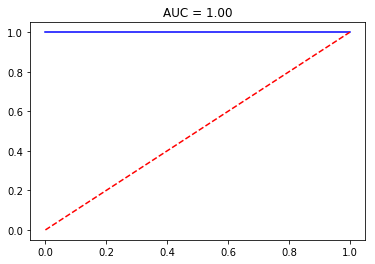

In [33]:
features2 = list(ts_2.columns)
features2.remove('y')
x_train = ts_2[features2]
y_train = ts_2['y']

# Training with best estimator returned by GridSearchCV
rf_classifier = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=-2, oob_score=False, random_state=1,
            verbose=0, warm_start=False).fit(x_train, y_train)
y_pred = rf_classifier.predict(x_train)
metricas_modelos(y_train, y_pred)

La matriz de confusión es 
[[159  31]
 [  0  10]]
Precisión: 0.845
Exactitud: 0.243902439024
Exhaustividad: 1.0
F1: 0.392156862745
AUC: 0.918421052632
GINI : 0.836842105263
KS : 0


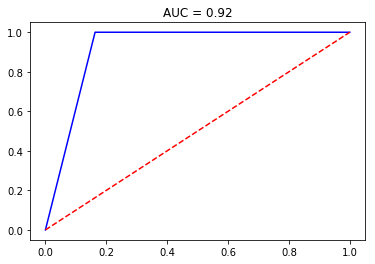

In [34]:
features3 = list(ts_3.columns)
features3.remove('y')

y_pred = rf_classifier.predict(ts_3[features3])
metricas_modelos(ts_3['y'], y_pred)

### Step 5. Test your code with the following stocks, create a table with KS and GINI for development and hold out for all the parameter combination below each stock.
##### - ndays2hold = 10 days / 20 days / 40 days
##### - ndays2history = 200 days / 400 days / 800 days
##### - aggressive = True / False

In [9]:
def ModelValidation (ts_2,ts_3):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import ParameterGrid, GridSearchCV
    
    param_grid = { 
    'n_estimators': [10,20,50],
    'max_features': [0.3,0.5,0.7,'log2','sqrt'],
    'criterion': ['gini','entropy'],
    'class_weight': [None,'balanced','balanced_subsample']
    }
    
    features2 = list(ts_2.columns)
    features2.remove('y')
  
    rfc=RandomForestClassifier(random_state=1,n_jobs=-2)

    gs = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 10,n_jobs=-2 ,scoring='roc_auc')
    gs.fit(ts_2[features2], ts_2['y'])
    Best_model = gs.best_estimator_
    
    rf_classifier = Best_model.fit(ts_2[features2], ts_2['y'])
    y_pred = rf_classifier.predict(ts_2[features2])
    metricas_modelos(ts_2['y'], y_pred)
    
    features3 = list(ts_3.columns)
    features3.remove('y')

    y_pred_2 = rf_classifier.predict(ts_3[features3])
    metricas_modelos(ts_3['y'], y_pred_2)

In [10]:
def Final (stock_ticket, ndays2hold, ndays2history=200, aggressive=False):
    ts_1 = create_lagged_series(stock_ticket, ndays2hold, ndays2history)
    dfDev = calculating_variables(ts_1, ndays2history, aggressive)
    dfOOT = create_OOT(ts_1, ndays2history, aggressive)
    ModelValidation (dfDev, dfOOT)

C:\Users\Alberto\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=11,center=False).max()
INFO:bokeh.core.state:Session output file './histogram.html' already exists, will be overwritten.
C:\Users\Alberto\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
C:\Users\Alberto\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
C:\Users\Alberto\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False

La matriz de confusión es 
[[134   0]
 [  0  66]]
Precisión: 1.0
Exactitud: 1.0
Exhaustividad: 1.0
F1: 1.0
AUC: 1.0
GINI : 1.0
KS : 0
La matriz de confusión es 
[[98 36]
 [ 0 66]]
Precisión: 0.82
Exactitud: 0.647058823529
Exhaustividad: 1.0
F1: 0.785714285714
AUC: 0.865671641791
GINI : 0.731343283582
KS : 0


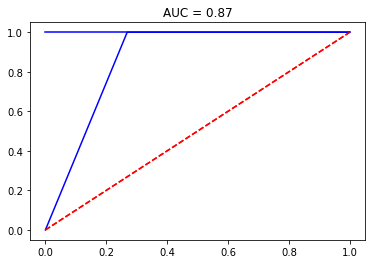

In [39]:
Final('AMZN', 10, 200, False) # Example 1

C:\Users\Alberto\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=11,center=False).max()
INFO:bokeh.core.state:Session output file './histogram.html' already exists, will be overwritten.
C:\Users\Alberto\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
C:\Users\Alberto\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
C:\Users\Alberto\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False

La matriz de confusión es 
[[190   0]
 [  0  10]]
Precisión: 1.0
Exactitud: 1.0
Exhaustividad: 1.0
F1: 1.0
AUC: 1.0
GINI : 1.0
KS : 0
La matriz de confusión es 
[[188   2]
 [  0  10]]
Precisión: 0.99
Exactitud: 0.833333333333
Exhaustividad: 1.0
F1: 0.909090909091
AUC: 0.994736842105
GINI : 0.989473684211
KS : 0


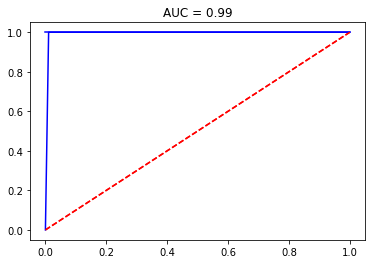

In [40]:
Final('GOOG', 10, 200, True) # Example 2

C:\Users\Eduardo\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=21,center=False).max()
C:\Users\Eduardo\Anaconda2\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\Eduardo\Anaconda2\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)
C:\Users\Eduardo\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
C:\Users\Eduardo\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
C

La matriz de confusión es 
[[380   0]
 [  0  20]]
Precisión: 1.0
Exactitud: 1.0
Exhaustividad: 1.0
F1: 1.0
AUC: 1.0
GINI : 1.0
KS : 0
La matriz de confusión es 
[[380   0]
 [  5  15]]
Precisión: 0.9875
Exactitud: 1.0
Exhaustividad: 0.75
F1: 0.857142857143
AUC: 0.875
GINI : 0.75
KS : 0


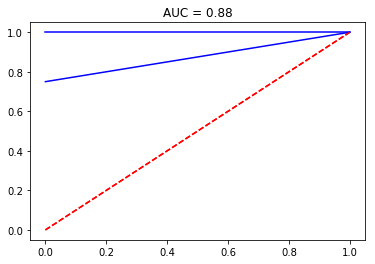

In [11]:
Final('JNJ', 20, 400, True) # Example 3

C:\Users\Eduardo\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=21,center=False).max()
INFO:bokeh.core.state:Session output file './histogram.html' already exists, will be overwritten.
C:\Users\Eduardo\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
C:\Users\Eduardo\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
C:\Users\Eduardo\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False

La matriz de confusión es 
[[134   0]
 [  0  66]]
Precisión: 1.0
Exactitud: 1.0
Exhaustividad: 1.0
F1: 1.0
AUC: 1.0
GINI : 1.0
KS : 0
La matriz de confusión es 
[[100  34]
 [  0  66]]
Precisión: 0.83
Exactitud: 0.66
Exhaustividad: 1.0
F1: 0.795180722892
AUC: 0.873134328358
GINI : 0.746268656716
KS : 0


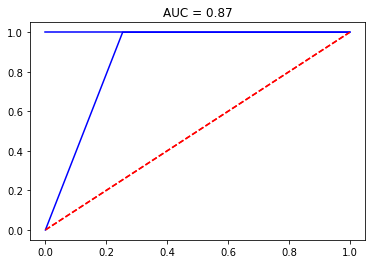

In [13]:
Final('AAPL', 20, 200, False) # Example 4